In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from scipy import stats
from statsmodels.stats import weightstats as stests

pd.set_option("max_columns", None)

In [2]:
df = pd.read_csv("data/airline_sample_150k.csv")

In [3]:
df.head(2)

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,wheels_on,taxi_in,crs_arr_time,arr_time,arr_delay,cancelled,cancellation_code,diverted,dup,crs_elapsed_time,actual_elapsed_time,air_time,flights,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name
0,2019-01-01,AA,AA_CODESHARE,AA,5241,OH,N703PS,5241,11057,CLT,"Charlotte, NC",12448,JAN,"Jackson/Vicksburg, MS",2054,2119.0,25.0,22.0,2141.0,2213.0,5.0,2149,2218.0,29.0,0,NaN,0,N,115,119.0,92.0,1,562,25.0,0.0,4.0,0.0,0.0,NaN,NaN,NaN,NaN
1,2019-01-01,NK,NK,NK,115,NK,N525NK,115,10821,BWI,"Baltimore, MD",11292,DEN,"Denver, CO",1955,1953.0,-2.0,16.0,2009.0,2204.0,8.0,2157,2212.0,15.0,0,NaN,0,N,242,259.0,235.0,1,1491,0.0,0.0,15.0,0.0,0.0,NaN,NaN,NaN,NaN


In [4]:
# Checking nulls
df.isnull().values.any()

True

In [5]:
# dropping all cancelled flights since they will skew the model
df = df[df['cancelled'] != 1]

# same reasoning for dropping diverted flights
df = df[df['diverted'] != 1]

# dropping the no_name column comprised of commas since this is a csv
df = df.drop('no_name', axis = 1)

In [6]:
# dropping columns that don't have any intuitive
df = df.drop(axis = 1, labels = ['branded_code_share', 'mkt_carrier_fl_num', 'tail_num',
                                 'op_carrier_fl_num', 'cancelled', 'cancellation_code',
                                 'diverted', 'flights', 'first_dep_time', 'total_add_gtime',
                                 'longest_add_gtime'])

In [7]:
df['dep_delay'].isnull().sum()

44

In [8]:
df.dropna(subset = ["dep_delay"], inplace = True)

In [9]:
df['total_dep_delay'] = (df['carrier_delay'] + df['weather_delay']
             + df['nas_delay'] + df['security_delay'] + df['late_aircraft_delay'])

df_delays = df.loc[(df['total_dep_delay'] != np.NaN)]
df['total_dep_delay'].fillna(0, inplace=True)
df['total_dep_delay'].head()

0    29.0
1    15.0
2    94.0
3     0.0
4     0.0
Name: total_dep_delay, dtype: float64

In [10]:
df_delays = df_delays[df_delays['total_dep_delay'] > 0]

In [11]:
carrier_flights = df['mkt_unique_carrier'].groupby(df['mkt_unique_carrier']).count()
carrier_delays = df_delays['total_dep_delay'].groupby(df_delays['mkt_unique_carrier']).count()
carrier_avg_time = df['air_time'].groupby(df['mkt_unique_carrier']).mean()
carrier_avg_dist = df['distance'].groupby(df['mkt_unique_carrier']).mean()
carrier_avg_delay = df['total_dep_delay'].groupby(df['mkt_unique_carrier']).mean()
carrier_avg_taxiIn = df['taxi_in'].groupby(df['mkt_unique_carrier']).mean()
carrier_avg_taxiOut = df['taxi_out'].groupby(df['mkt_unique_carrier']).mean()

In [12]:
summary_table_carrier = pd.concat([carrier_flights, carrier_delays, carrier_avg_time, carrier_avg_dist,
                                   carrier_avg_delay, carrier_avg_taxiIn, carrier_avg_taxiOut], axis=1)

summary_table_carrier.columns = ['total_flights', 'total_delays', 'avg_flight_time',
                         'avg_flight_distance', 'avg_departure_delay', 
                         'avg_taxi_in', 'avg_taxi_out']

summary_table_carrier

,total_flights,total_delays,avg_flight_time,avg_flight_distance,avg_departure_delay,avg_taxi_in,avg_taxi_out
mkt_unique_carrier,,,,,,,
AA,40110,8047,100.594615,700.380055,13.400723,9.026851,18.721466
AS,8338,1418,132.718158,965.170904,8.246222,7.256057,17.199568
B6,5828,1563,149.490906,1106.462766,20.368051,7.328243,18.198010
DL,34416,5485,99.148971,699.979719,11.663848,7.384589,18.587517
F9,2559,672,138.051973,1030.248925,18.957405,10.393513,16.596327
G4,1959,409,117.210311,874.310873,15.364982,6.706483,13.012251
HA,1771,196,88.963201,639.753247,5.606437,6.974299,11.621495
NK,3825,696,135.811765,1015.112157,12.762092,9.921569,15.131242
UA,30200,6529,110.926391,791.775364,17.596159,8.109735,20.185662


In [13]:
df.head()

,fl_date,mkt_unique_carrier,mkt_carrier,op_unique_carrier,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,wheels_on,taxi_in,crs_arr_time,arr_time,arr_delay,dup,crs_elapsed_time,actual_elapsed_time,air_time,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,total_dep_delay
0,2019-01-01,AA,AA,OH,11057,CLT,"Charlotte, NC",12448,JAN,"Jackson/Vicksburg, MS",2054,2119.0,25.0,22.0,2141.0,2213.0,5.0,2149,2218.0,29.0,N,115,119.0,92.0,562,25.0,0.0,4.0,0.0,0.0,29.0
1,2019-01-01,NK,NK,NK,10821,BWI,"Baltimore, MD",11292,DEN,"Denver, CO",1955,1953.0,-2.0,16.0,2009.0,2204.0,8.0,2157,2212.0,15.0,N,242,259.0,235.0,1491,0.0,0.0,15.0,0.0,0.0,15.0
2,2019-01-01,AA,AA,OO,11433,DTW,"Detroit, MI",13930,ORD,"Chicago, IL",1620,1651.0,31.0,60.0,1751.0,1750.0,33.0,1649,1823.0,94.0,N,89,152.0,59.0,235,2.0,0.0,63.0,0.0,29.0,94.0
3,2019-01-01,AA,AA,OO,14109,PIB,"Hattiesburg/Laurel, MS",13241,MEI,"Meridian, MS",545,536.0,-9.0,12.0,548.0,605.0,3.0,623,608.0,-15.0,N,38,32.0,17.0,69,NaN,NaN,NaN,NaN,NaN,0.0
4,2019-01-01,DL,DL,OO,12884,LAN,"Lansing, MI",11433,DTW,"Detroit, MI",1000,953.0,-7.0,29.0,1022.0,1047.0,7.0,1101,1054.0,-7.0,N,61,61.0,25.0,74,NaN,NaN,NaN,NaN,NaN,0.0


In [14]:
# Doing a left join here to map the summary data onto the carriers
df = df.join(summary_table_carrier, on = 'mkt_unique_carrier', how = 'left')
df.head(2)

,fl_date,mkt_unique_carrier,mkt_carrier,op_unique_carrier,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,wheels_on,taxi_in,crs_arr_time,arr_time,arr_delay,dup,crs_elapsed_time,actual_elapsed_time,air_time,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,total_dep_delay,total_flights,total_delays,avg_flight_time,avg_flight_distance,avg_departure_delay,avg_taxi_in,avg_taxi_out
0,2019-01-01,AA,AA,OH,11057,CLT,"Charlotte, NC",12448,JAN,"Jackson/Vicksburg, MS",2054,2119.0,25.0,22.0,2141.0,2213.0,5.0,2149,2218.0,29.0,N,115,119.0,92.0,562,25.0,0.0,4.0,0.0,0.0,29.0,40110,8047,100.594615,700.380055,13.400723,9.026851,18.721466
1,2019-01-01,NK,NK,NK,10821,BWI,"Baltimore, MD",11292,DEN,"Denver, CO",1955,1953.0,-2.0,16.0,2009.0,2204.0,8.0,2157,2212.0,15.0,N,242,259.0,235.0,1491,0.0,0.0,15.0,0.0,0.0,15.0,3825,696,135.811765,1015.112157,12.762092,9.921569,15.131242


In [15]:
df_zscores = np.abs(stats.zscore(df["dep_delay"], nan_policy = 'omit'))
# Setting a boolean variable classifying data falling within 3 std of the mean as True
df_non_outliers = df_zscores <= 3

# Masking the values to remove outliers
# Setting a column of values where z scores are less than 3
df['dep_delay_z_3'] = df["dep_delay"][df_non_outliers]

In [16]:
df.shape

(155747, 39)

In [17]:
df = df.dropna(axis=0, subset=['dep_delay_z_3'])
df.isnull().sum()

fl_date                     0
mkt_unique_carrier          0
mkt_carrier                 0
op_unique_carrier           0
origin_airport_id           0
origin                      0
origin_city_name            0
dest_airport_id             0
dest                        0
dest_city_name              0
crs_dep_time                0
dep_time                    0
dep_delay                   0
taxi_out                   56
wheels_off                 56
wheels_on                  56
taxi_in                    56
crs_arr_time                0
arr_time                    0
arr_delay                  31
dup                         0
crs_elapsed_time            0
actual_elapsed_time         0
air_time                   56
distance                    0
carrier_delay          125877
weather_delay          125877
nas_delay              125877
security_delay         125877
late_aircraft_delay    125877
total_dep_delay             0
total_flights               0
total_delays                0
avg_flight

In [18]:
df.shape

(153192, 39)

In [19]:
df.head(2)

,fl_date,mkt_unique_carrier,mkt_carrier,op_unique_carrier,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,wheels_on,taxi_in,crs_arr_time,arr_time,arr_delay,dup,crs_elapsed_time,actual_elapsed_time,air_time,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,total_dep_delay,total_flights,total_delays,avg_flight_time,avg_flight_distance,avg_departure_delay,avg_taxi_in,avg_taxi_out,dep_delay_z_3
0,2019-01-01,AA,AA,OH,11057,CLT,"Charlotte, NC",12448,JAN,"Jackson/Vicksburg, MS",2054,2119.0,25.0,22.0,2141.0,2213.0,5.0,2149,2218.0,29.0,N,115,119.0,92.0,562,25.0,0.0,4.0,0.0,0.0,29.0,40110,8047,100.594615,700.380055,13.400723,9.026851,18.721466,25.0
1,2019-01-01,NK,NK,NK,10821,BWI,"Baltimore, MD",11292,DEN,"Denver, CO",1955,1953.0,-2.0,16.0,2009.0,2204.0,8.0,2157,2212.0,15.0,N,242,259.0,235.0,1491,0.0,0.0,15.0,0.0,0.0,15.0,3825,696,135.811765,1015.112157,12.762092,9.921569,15.131242,-2.0


In [20]:
df = df.reset_index(drop = True)

In [21]:
# converting FL_DATE to datetime type for easy wrangling
df['fl_date'] = pd.to_datetime(df['fl_date'], format='%Y-%m-%d')

In [22]:
# creating MONTH from FL_DATE
months = [df['fl_date'][i].month for i in range(len(df['fl_date']))]
df.insert(1, 'month', value=months)

In [23]:
# creating WEEKDAY from FL_DATE
weekdays = [df['fl_date'][i].weekday() for i in range(len(df['fl_date']))]
df.insert(2, 'weekday', value=weekdays)

print(f'Dimension increase to: {len(df.columns)}')

Dimension increase to: 41


In [24]:
df.month.describe()

count    153192.000000
mean          6.582609
std           3.407804
min           1.000000
25%           4.000000
50%           7.000000
75%          10.000000
max          12.000000
Name: month, dtype: float64

In [25]:
# transform categorical features into dummies
cols_dummies = pd.get_dummies(df[['mkt_unique_carrier']])

# extract numerical features
cols_num = df[['month', 'weekday', 'distance','total_flights', 'total_delays',
               'avg_flight_time', 'avg_flight_distance', 'avg_departure_delay',
               'avg_taxi_in', 'avg_taxi_out', 'arr_delay']]

# combine numerical and categorical (dummies) features into final dataframe
df = pd.concat([cols_num, cols_dummies], axis=1)

print(f'Final Dimension: {len(df.columns)}')

Final Dimension: 22


In [26]:
df.head(2)

,month,weekday,distance,total_flights,total_delays,avg_flight_time,avg_flight_distance,avg_departure_delay,avg_taxi_in,avg_taxi_out,arr_delay,mkt_unique_carrier_AA,mkt_unique_carrier_AS,mkt_unique_carrier_B6,mkt_unique_carrier_DL,mkt_unique_carrier_F9,mkt_unique_carrier_G4,mkt_unique_carrier_HA,mkt_unique_carrier_NK,mkt_unique_carrier_UA,mkt_unique_carrier_VX,mkt_unique_carrier_WN
0,1,1,562,40110,8047,100.594615,700.380055,13.400723,9.026851,18.721466,29.0,1,0,0,0,0,0,0,0,0,0,0
1,1,1,1491,3825,696,135.811765,1015.112157,12.762092,9.921569,15.131242,15.0,0,0,0,0,0,0,0,1,0,0,0


In [27]:
df.describe()

,month,weekday,distance,total_flights,total_delays,avg_flight_time,avg_flight_distance,avg_departure_delay,avg_taxi_in,avg_taxi_out,arr_delay,mkt_unique_carrier_AA,mkt_unique_carrier_AS,mkt_unique_carrier_B6,mkt_unique_carrier_DL,mkt_unique_carrier_F9,mkt_unique_carrier_G4,mkt_unique_carrier_HA,mkt_unique_carrier_NK,mkt_unique_carrier_UA,mkt_unique_carrier_VX,mkt_unique_carrier_WN
count,153192.000000,153192.000000,153192.000000,153192.000000,153192.000000,153192.000000,153192.000000,153192.000000,153192.000000,153192.000000,153161.000000,153192.000000,153192.000000,153192.000000,153192.000000,153192.000000,153192.000000,153192.000000,153192.000000,153192.000000,153192.000000,153192.000000
mean,6.582609,2.937993,770.904120,29167.614686,5540.935721,107.964256,770.407765,13.110390,7.678290,17.490605,1.023322,0.257748,0.054135,0.036928,0.221108,0.016254,0.012481,0.011495,0.024551,0.192269,0.001142,0.171889
std,3.407804,1.994879,586.930585,11315.063122,2248.104485,13.398931,110.395512,3.360805,1.332707,2.749045,28.498135,0.437396,0.226284,0.188584,0.414995,0.126452,0.111020,0.106599,0.154752,0.394084,0.033780,0.377285
min,1.000000,0.000000,31.000000,177.000000,33.000000,88.963201,639.753247,5.606437,5.294572,11.621495,-86.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,1.000000,342.000000,26564.000000,4822.000000,100.594615,700.380055,11.663848,7.310196,17.199568,-15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.000000,3.000000,605.000000,30200.000000,5485.000000,103.561851,745.794910,13.400723,7.384589,18.587517,-6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,10.000000,5.000000,1008.000000,40110.000000,8047.000000,110.926391,791.775364,15.364982,9.026851,18.721466,7.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,12.000000,6.000000,5095.000000,40110.000000,8047.000000,189.039548,1439.983051,20.368051,10.393513,20.751412,276.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [28]:
# This was the first attempt of dropped columns
#df_clean = df.drop(['total_delays','total_flights', 'avg_flight_time', 'avg_flight_distance', 
#                    'avg_taxi_in', 'avg_taxi_out', 'arr_delay'], axis = 1)

In [29]:
df_clean = df.drop(['avg_taxi_in', 'avg_taxi_out', 'arr_delay', 'mkt_unique_carrier_VX'], axis = 1)

In [30]:
df_clean.head(2)

,month,weekday,distance,total_flights,total_delays,avg_flight_time,avg_flight_distance,avg_departure_delay,mkt_unique_carrier_AA,mkt_unique_carrier_AS,mkt_unique_carrier_B6,mkt_unique_carrier_DL,mkt_unique_carrier_F9,mkt_unique_carrier_G4,mkt_unique_carrier_HA,mkt_unique_carrier_NK,mkt_unique_carrier_UA,mkt_unique_carrier_WN
0,1,1,562,40110,8047,100.594615,700.380055,13.400723,1,0,0,0,0,0,0,0,0,0
1,1,1,1491,3825,696,135.811765,1015.112157,12.762092,0,0,0,0,0,0,0,1,0,0


In [31]:
# Metrics to be used for evaluation of models

In [32]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [33]:
X = df_clean
y = df['arr_delay']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)

In [35]:
# Calculates the specificity
def calc_specificity(y, y_pred, thresh):
    return sum((y_pred < thresh) & (y == 0)) / sum(y == 0)

def print_metrics(y_data, y_pred, thresh):
    # Defining the metrics we would like to return
    auc = roc_auc_score(y_data, y_pred)
    accuracy = accuracy_score(y_data, (y_pred > thresh))
    recall = recall_score(y_data, (y_pred > thresh))
    specficity = calc_specificity(y_data, y_pred, thresh)
    r2 = r2_score(y_data, y_pred)
    
    # Printing the values
    print('AUC: %.3f' %auc)
    print('Accuracy: %.3f' %accuracy)
    print('Recall: %.3f' %recall)
    print('Precision: %.3f' %precision)
    print('Specificity: %.3f' %specficity)
    print('R2: %.3f' %r2)

## Scaling the data

In [36]:
#scaler = StandardScaler()
#scaler.fit(X_train)
#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)

## Linear Regression model

In [37]:
#from sklearn.linear_model import LinearRegression

#reg = LinearRegression()
# Creating a polynomial feature set

#reg.fit(X_train, y_train)

## Logistic Regression model

In [38]:
# Model useful for classification of binary data

#from sklearn.linear_model import LogisticRegression
#lr = LogisticRegression()
#lr.fit(X_train, y_train)

## Stochastic Gradient Descent model

In [39]:
#from sklearn.linear_model import SGDRegressor
#sgdr = SGDRegressor(loss = 'squared_loss', alpha = 0.1)
#sgdr.fit(X_train, y_train)

## Naive Bayes model

In [40]:
# Model useful for regression analysis

#from sklearn.naive_bayes import GaussianNB
#nb = GaussianNB()
#nb.fit(X_train, y_train)

## Random Forest Regressor

In [41]:
from sklearn.ensemble import RandomForestRegressor

In [42]:
# Running the model a first time showed that there were null values in y_train
# We drop the values here since there were only 21 out of the 120k+ records
y_train = y_train.ffill(axis = 0)

In [43]:
# Same reasoning used here as y_train issue
y_test = y_test.ffill(axis = 0)

In [44]:
#X_train = X_train.drop(['total_flights', 'total_delays', 'avg_flight_distance'], axis = 1)
#X_test = X_test.drop(['total_flights', 'total_delays', 'avg_flight_distance'], axis = 1)

In [45]:
model = RandomForestRegressor()
params_grid = {'n_estimators' : [10, 20, 50], 'max_depth' : [4, 5, 6]}

models = GridSearchCV(model, params_grid)
models.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [4, 5, 6], 'n_estimators': [10, 20, 50]})

In [46]:
# This is r2 score
models.score(X_test, y_test)

0.01241043947275855

In [47]:
y_train.isnull().sum()

0

In [48]:
y_pred = models.predict(X_test)

In [49]:
from sklearn.metrics import mean_squared_error

In [50]:
# This is the focus, we should try to reduce this as much as possible
mean_squared_error(y_test, y_pred)

806.4909835964693

In [51]:
len(X_train),len(y_train),len(X_test),len(y_test)

(122553, 122553, 30639, 30639)

In [52]:
be_models = models.best_estimator_

In [53]:
be_models.score(X_train, y_train)

0.016620307739806495

In [54]:
be_models.score(X_test, y_test)

0.01241043947275855

Feature: 0, Score: 0.31468
Feature: 1, Score: 0.12750
Feature: 2, Score: 0.22136
Feature: 3, Score: 0.00392
Feature: 4, Score: 0.00465
Feature: 5, Score: 0.00981
Feature: 6, Score: 0.02036
Feature: 7, Score: 0.06407
Feature: 8, Score: 0.00031
Feature: 9, Score: 0.00165
Feature: 10, Score: 0.00746
Feature: 11, Score: 0.21211
Feature: 12, Score: 0.00261
Feature: 13, Score: 0.00028
Feature: 14, Score: 0.00028
Feature: 15, Score: 0.00296
Feature: 16, Score: 0.00243
Feature: 17, Score: 0.00357


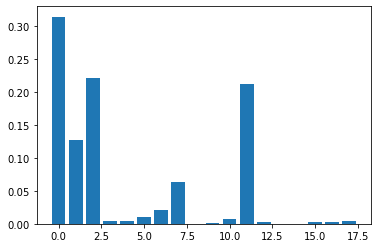

In [55]:
importance = models.best_estimator_.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

## Sample Prediction

In [56]:
import pandas as pd
import numpy as np
import psycopg2

In [57]:
conn = psycopg2.connect(
    host="mid-term-project.ca2jkepgjpne.us-east-2.rds.amazonaws.com",
    database="mid_term_project",
    user="lhl_student",
    password="lhl_student",
port = "5432")
cur = conn.cursor()
cur.execute("select * from flights_test where (fl_date <= '2020-01-07' AND fl_date >= '2020-01-01');")
all2 = cur.fetchall()
test_cols = [i[0] for i in cur.description]
df_test = pd.DataFrame(all2,columns = test_cols)

In [58]:
df_test.shape

(150623, 20)

In [59]:
df_test.describe()

,mkt_carrier_fl_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,crs_arr_time,crs_elapsed_time,flights,distance
count,150623.000000,150623.000000,150623.000000,150623.000000,150623.000000,150623.000000,150623.000000,150623.0,150623.000000
mean,2825.682658,2825.490582,12700.684344,12700.653333,1334.061153,1485.525770,143.286185,1.0,789.441739
std,1862.698573,1862.574715,1523.101482,1522.773801,493.774648,524.008413,73.111577,0.0,593.936415
min,1.000000,1.000000,10135.000000,10135.000000,2.000000,1.000000,22.000000,1.0,31.000000
25%,1196.000000,1196.000000,11292.000000,11292.000000,919.000000,1102.000000,90.000000,1.0,354.000000
50%,2437.000000,2437.000000,12889.000000,12889.000000,1325.000000,1515.000000,125.000000,1.0,629.000000
75%,4491.000000,4490.000000,14057.000000,14057.000000,1740.000000,1920.000000,174.000000,1.0,1028.000000
max,6799.000000,6799.000000,16869.000000,16869.000000,2359.000000,2400.000000,700.000000,1.0,5095.000000


In [60]:
# We will replicate all the transformations made on the training dataset here on the testing dateset

In [61]:
df_test = df_test.reset_index(drop = True)

# converting FL_DATE to datetime type for easy wrangling
df_test['fl_date'] = pd.to_datetime(df_test['fl_date'], format='%Y-%m-%d')

# creating MONTH from FL_DATE
months = [df_test['fl_date'][i].month for i in range(len(df_test['fl_date']))]
df_test.insert(1, 'month', value=months)

# creating WEEKDAY from FL_DATE
weekdays = [df_test['fl_date'][i].weekday() for i in range(len(df_test['fl_date']))]
df_test.insert(2, 'weekday', value=weekdays)

print(f'Dimension increase to: {len(df_test.columns)}')

Dimension increase to: 22


In [62]:
df_test = df_test.join(summary_table_carrier, on = 'mkt_unique_carrier', how = 'left')

In [63]:
df_test.head(2)

,fl_date,month,weekday,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,crs_arr_time,dup,crs_elapsed_time,flights,distance,total_flights,total_delays,avg_flight_time,avg_flight_distance,avg_departure_delay,avg_taxi_in,avg_taxi_out
0,2020-01-01,1,2,WN,WN,WN,5888,WN,N951WN,5888,13891,ONT,"Ontario, CA",14771,SFO,"San Francisco, CA",1810,1945,N,95,1,363,26564,4822,103.561851,745.79491,9.356083,5.294572,12.276577
1,2020-01-01,1,2,WN,WN,WN,6276,WN,N467WN,6276,13891,ONT,"Ontario, CA",14771,SFO,"San Francisco, CA",1150,1320,N,90,1,363,26564,4822,103.561851,745.79491,9.356083,5.294572,12.276577


In [65]:
# transform categorical features into dummies
cols_dummies = pd.get_dummies(df_test[['mkt_unique_carrier']])

# extract numerical features
cols_num = df_test[['month', 'weekday', 'distance','total_flights', 'total_delays',
               'avg_flight_time', 'avg_flight_distance', 'avg_departure_delay',
               'avg_taxi_in', 'avg_taxi_out',]]

# combine numerical and categorical (dummies) features into final dataframe
df_test_final = pd.concat([cols_num, cols_dummies], axis=1)

print(f'Final Dimension: {len(df.columns)}')

Final Dimension: 22


In [66]:
#cols_num2 = cols_num.drop_duplicates()

In [ ]:
#cols_num2.head()

In [69]:
df_test = df_test.join(summary_table_carrier, on = 'mkt_unique_carrier', how = 'left')

ValueError: columns overlap but no suffix specified: Index(['total_flights', 'total_delays', 'avg_flight_time',
       'avg_flight_distance', 'avg_departure_delay', 'avg_taxi_in',
       'avg_taxi_out'],
      dtype='object')

In [ ]:
df_test_final = df_test_final.drop(axis = 1, labels = ['avg_taxi_in', 'avg_taxi_out'])

In [ ]:
df_test_final.head(2)

In [ ]:
X_oosample = df_test_final

In [ ]:
df_test_final = df_test_final.assign(predicted_delay = models.predict(X_oosample))

In [ ]:
df_test_final.head()